In [3]:
import pylab
import imageio
import numpy as np
import math
%matplotlib inline

In [4]:
fname = "~/Downloads/barbecue.mp4"
#fname = "~/test2-skew.mp4"
fname = "~/shrwq.mp4"
outname = fname.replace(".mp4", "-skew2.mp4")

In [1]:
reader = imageio.get_reader(fname, "ffmpeg")
meta = reader.get_meta_data()
writer = imageio.get_writer(outname, fps=meta["fps"])
W, H = meta["size"]
print(reader)

NameError: name 'imageio' is not defined

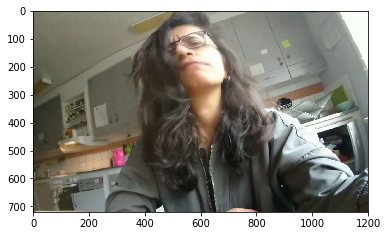

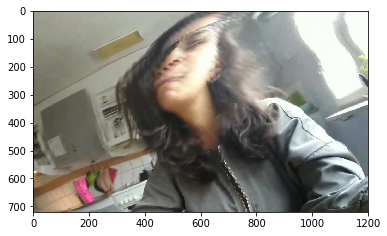

In [60]:
horizontal = False

if horizontal:
    length = W
else:
    length = H
    
zero = length/2
#delay_fn = lambda x: math.log(((x-zero)/100)**2 + 1)
delay_fn = lambda x: ((x-zero)/2)**2
#delay_fn = lambda x: abs(x-zero)/2

scale = 1/delay_fn(length)
maxdelay = 15 # frames

nframes = reader.count_frames()
buffer = None

for i in range(nframes + 2*maxdelay):
    if i < nframes:
        f = reader.get_data(i).astype(np.float)
        if horizontal:
            f = f.transpose(1,0,2)
        if buffer is None:
            buffer = [f.copy()] * (maxdelay + 2)
        buffer.append(f.copy())
    else:
        buffer.append(buffer[-1])
        
    buffer = buffer[-maxdelay-2:]
    
    fnew = np.zeros_like(buffer[-1])
    for row in range(length):
        dt, dt_frac = divmod(delay_fn(row)*scale*maxdelay, 1)
        dt = int(dt) + 1
        fnew[row] = buffer[-dt][row] + (buffer[-dt - 1][row] - buffer[-dt][row]) * dt_frac
    if horizontal:
        fnew = fnew.transpose(1,0,2)
    writer.append_data(fnew.astype(np.uint8))
    
writer.close()

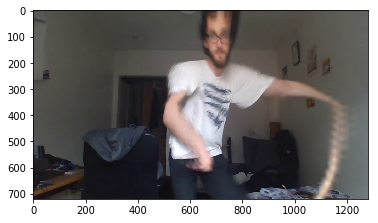

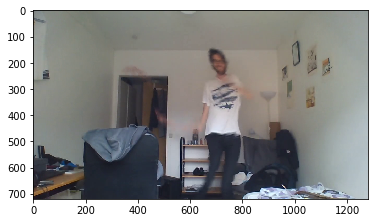

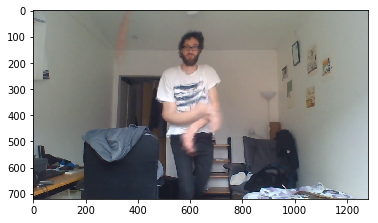

In [232]:
# vertical
nframes = reader.count_frames()
buffer = None
for i in range(nframes + int(W/30.1)):
    if i < nframes:
        f = reader.get_data(i).astype(np.float).transpose(1,0,2)
        if buffer is None:
            buffer = [f.copy()] * W
        buffer.append(f.copy())
    else:
        buffer.append(buffer[-1])
        
    buffer = buffer[-W:]
    #fnew = buffer[-1].copy()
    fnew = np.zeros_like(buffer[-1])
    for row in range(f.shape[0]):
        #print(buffer[-row][row])
        dt, dt_frac = divmod(abs(row-f.shape[0]/2)/30.1, 1)
        dt = int(dt) + 1
        fnew[row] = buffer[-dt][row] + (buffer[-dt - 1][row] - buffer[-dt][row]) * dt_frac
        #fnew[row] = buffer[-dt][row] + (buffer[-dt - 1][row] - buffer[-dt][row])
    writer.append_data(fnew.transpose(1,0,2).astype(np.uint8))
    if i in (50,100,200):
        fig = pylab.figure()
        pylab.imshow(fnew.transpose(1,0,2).astype(np.uint8))
writer.close()

In [209]:


reader = imageio.get_reader(fname, "ffmpeg")
meta = reader.get_meta_data()
writer = imageio.get_writer(outname, fps=meta["fps"])
W, H = meta["size"]

delay = np.zeros((H,W), dtype=float)
for y in range(H):
    for x in range(W):
        delay[y,x] = np.sqrt((2*x/W-1)**2 + (2*y/H-1)**2)*100
        
delay = delay.astype(np.int)
n_interp = 10
maxdel = delay.max() // n_interp + 1

# Circle delay
nframes = reader.count_frames()
buffer = None
for i in range(nframes + maxdel*2):
    print(i)
    if i < nframes:
        f = reader.get_data(i).astype(np.float)
        if buffer is None:
            # init buffer
            buffer = np.stack([f] * maxdel*2)
            print("buffer init'd")
    else:
        f = fnew.copy()
    
    # interpolate new frame
    step = (f - buffer[-1]) / n_interp
    for j in range(1, n_interp):
        buffer = np.append(buffer, [buffer[-1] + step],axis=0)
    
    buffer = np.append(buffer, [f.copy()],axis=0)
    
    print(buffer.shape)

    fnew = buffer[-delay, np.arange(H), np.arange(W), :]
    
    writer.append_data(fnew.astype(np.uint8))
    if i in (50,100,200):
        fig = pylab.figure()
        pylab.imshow(fnew.astype(np.uint8))
writer.close()

0
buffer init'd
(40, 720, 1280, 3)


IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (720,1280) (720,) (1280,) 

In [236]:
reader = imageio.get_reader(fname, "ffmpeg")
W, H = reader.get_meta_data()["size"]
nframes = reader.count_frames()
buffer = None

f = reader.get_data(0).astype(np.float)
buffer = np.stack([f] * 30)

# interpolate new frame
step = (f - buffer[-1]) / n_interp
for j in range(1, n_interp):
    buffer = np.append(buffer, [buffer[-1] + step],axis=0)

buffer = np.append(buffer, [f.copy()],axis=0)

print(buffer.shape)

(40, 720, 1200, 3)


In [237]:
buffer[-delay, np.arange(H), np.arange(W)].shape

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (720,1280) (720,) (1200,) 

In [146]:
a = np.zeros((5,5,5), dtype=np.int)
r = np.arange(5)
r.shape = (1,1,5)
a += r
r.shape = (1,5,1)
a += r * 10
r.shape = (5,1,1)
a += r * 100
i = np.matrix("0,1,2;1,2,3;2,3,4")
a[i,i,i]

array([[  0, 111, 222],
       [111, 222, 333],
       [222, 333, 444]])

In [19]:
s = 5
x = np.stack([np.array([1,11,111,1111,11111])]*3).transpose()
b = np.stack([x]*5)
#b.shape = (1,5,5)
a = b.reshape(1,5,5,3)
for i in range(1,9):
    a = np.append(a,[a[-1]+b],axis=0)
    
dly = np.zeros((s,s), np.int)
for i in range(s//2 + 1):
    dly[i:-i,i:-i] += 1

for i in range(a.shape[0]):
    new = a[i+dly,np.arange(5),np.arange(5),:]
    print(new)

[[[    1     1     1]
  [   11    11    11]
  [  111   111   111]
  [ 1111  1111  1111]
  [11111 11111 11111]]

 [[    1     1     1]
  [   22    22    22]
  [  222   222   222]
  [ 2222  2222  2222]
  [11111 11111 11111]]

 [[    1     1     1]
  [   22    22    22]
  [  333   333   333]
  [ 2222  2222  2222]
  [11111 11111 11111]]

 [[    1     1     1]
  [   22    22    22]
  [  222   222   222]
  [ 2222  2222  2222]
  [11111 11111 11111]]

 [[    1     1     1]
  [   11    11    11]
  [  111   111   111]
  [ 1111  1111  1111]
  [11111 11111 11111]]]
[[[    2     2     2]
  [   22    22    22]
  [  222   222   222]
  [ 2222  2222  2222]
  [22222 22222 22222]]

 [[    2     2     2]
  [   33    33    33]
  [  333   333   333]
  [ 3333  3333  3333]
  [22222 22222 22222]]

 [[    2     2     2]
  [   33    33    33]
  [  444   444   444]
  [ 3333  3333  3333]
  [22222 22222 22222]]

 [[    2     2     2]
  [   33    33    33]
  [  333   333   333]
  [ 3333  3333  3333]
  [22222 22222 2

IndexError: index 9 is out of bounds for axis 0 with size 9